In [1]:
import numpy as np
import pandas as pd
import json

In [2]:
import gzip
import seaborn as sns
import os
%matplotlib inline

In [3]:
import matplotlib.pyplot as plt
import re

In [4]:
data_dir = '../dataFiles/'
profiles_path = os.path.join(data_dir, 'linkedin.json')
print(os.listdir(data_dir))

['linkedIn_data.csv', 'typed_posts.csv', 'mbti_1.csv', 'mbti9k_comments.csv', '.DS_Store', 'tokenizing.ipynb', 'toy_data.csv', 'dataFile.csv', 'typed_comments.csv', 'Processed_LinkedIn_Data.csv', '.ipynb_checkpoints', 'pickle files', 'linkedin.json.gz', 'linkedin.json']


In [5]:
num_records = 0
for line in open(profiles_path):
    num_records += 1
print('Number of profiles', num_records)

Number of profiles 2985334


In [8]:
fields = set()
localities = []
industries = []
skills = []
specialities = []
interests = []
occupations = []
companies = []
schools = []
majors = []

for line in open(profiles_path):
    line = json.loads(line)
    
    fields.update(line.keys())
    
    localities.append(line['locality'] if 'locality' in line else '')
    industries.append(line['industry'] if 'industry' in line else '')
    skills.extend(line['skills'] if 'skills' in line else [])
    specialities.extend([s.strip() for s in line['specilities'].split(',')] if 'specilities' in line else [])
    interests.extend([s.strip() for s in line['interests'].split(',')] if 'interests' in line else [])
    occupations.extend([exp['title'] for exp in line['experience'] if 'title' in exp] if 'experience' in line else [])
    companies.extend([exp['org'] for exp in line['experience'] if 'org' in exp] if 'experience' in line else [])
    schools.extend([edu['name'] for edu in line['education'] if 'name' in edu] if 'education' in line else [])
    majors.extend([edu['major'] for edu in line['education'] if 'major' in edu] if 'education' in line else [])
    
print('JSON fields', len(fields), fields)

JSON fields 18 {'group', 'education', 'industry', 'name', 'interval', 'homepage', 'summary', 'specilities', 'also_view', 'url', 'locality', 'overview_html', 'experience', 'events', 'skills', 'interests', '_id', 'honors'}


In [8]:
skills = pd.Series(list(skills)).value_counts()
localities = pd.Series(list(localities)).value_counts()
industries = pd.Series(list(industries)).value_counts()
specialities = pd.Series(list(specialities)).value_counts()
interests = pd.Series(list(interests)).value_counts()
occupations = pd.Series(list(occupations)).value_counts()
companies = pd.Series(list(companies)).value_counts()
schools = pd.Series(list(schools)).value_counts()
majors = pd.Series(list(majors)).value_counts()

In [16]:
overview = {'skills':len(skills), 
            'localities':len(localities), 'industries':len(industries), 
            'specialities':len(specialities), 'interests':len(interests), 'occupations':len(occupations), 
            'comapnies':len(companies), 'schools':len(schools), 'majors':len(majors)}

In [17]:
overview

{'skills': 653628,
 'localities': 24598,
 'industries': 2646,
 'specialities': 861527,
 'interests': 557665,
 'occupations': 3500534,
 'comapnies': 3787170,
 'schools': 864915,
 'majors': 733611}

### Loading Profiles

In [6]:
num_profiles_loaded = 100000
profiles = []

for line in open(profiles_path):
    if len(profiles) < num_profiles_loaded:
        line = json.loads(line)
        profiles.append(line)
    else:
        break

### Loading Based on Location

In [76]:
# code block to get the local australian linkedIn profiles
profiles = []

for line in open(profiles_path):
    line = json.loads(line)
    
    fields.update(line.keys())
    
    #localities.append(line['locality'] if 'locality' in line else '')
    if 'locality' in line:
        if line['locality'] == 'Australia':
            profiles.append(line)

In [73]:
profiles[3030]['locality']

'Birmingham, Alabama Area'

In [77]:
from collections import defaultdict

dd = defaultdict(int)

for i in range(len(profiles)):
    try:
        if profiles[i]['locality'] == 'Australia':
            dd['Australia'] += 1
    except Exception as e:
        print(e)
            

In [7]:
# to get the job description
profiles[4405]['experience'][0]['desc']

'Working on new development Project involving changes to exisitng functionality , customizing peoplesoft delivered funcionality and buidling new components & process along with handling the integration between Peoplesoft CRM and Mainframe application of Medibank.Also working on Enhancements,Customizations , Bug fixes and Production support of Medibank Peoplesoft CRM ( Psoft CRM 8.1 and People Tools 8.2)'

In [78]:
dd

defaultdict(int, {'Australia': 3019})

In [117]:
# taking the latest experience of the employee
aus_companies = []

for i in range(len(profiles)):
    if len([exp['org'] for exp in profiles[i]['experience'] if 'org' in exp] if 'experience' in profiles[i] else []) > 1:
        aus_companies.append([exp['org'] for exp in profiles[i]['experience'] if 'org' in exp][0] if 'experience' in profiles[i] else [])

In [119]:

companies_dd = defaultdict(int)

for company in aus_companies:
    companies_dd[company] += 1

In [120]:
#[exp['org'] for exp in profiles[1]['experience'] if 'org' in exp] if 'experience' in profiles[1] else []

In [124]:
sorted([(val, key) for key, val in companies_dd.items()], reverse=True)[:10]

[(17, 'Newcrest Mining'),
 (9, 'National Australia Bank'),
 (7, 'Leighton Contractors'),
 (7, 'La Trobe University'),
 (7, 'BHP Billiton'),
 (5, 'Tabcorp'),
 (5, 'Monash University'),
 (5, 'Diversified Exhibitions Australia'),
 (4, 'Westpac'),
 (4, 'Toll Holdings Limited')]

### Loading Based on Companies

In [126]:
# list of desirable companies
desired_companies = ['IBM', 'Ernst & Young', 'Accenture', 'Microsoft', 'Hewlett-Packard', 'Deloitte', 'KPMG', 'PwC', 'Google', 'Tata Consultancy Services']

In [12]:
# Checking just Big4
desired_companies = ['Ernst & Young','Deloitte', 'KPMG', 'PwC']

In [11]:
len(companies)

9542379

In [13]:
# code block to get the desired company profiles
# only collecting the latest job history

profiles = []

for line in open(profiles_path):
    line = json.loads(line)
    
    fields.update(line.keys())
    
    #localities.append(line['locality'] if 'locality' in line else '')
    if 'experience' in line:
        if 'org' in line['experience'][0]:  
            if line['experience'][0]['org'] in desired_companies:
                profiles.append(line)
            
# companies.extend([exp['org'] for exp in line['experience'] if 'org' in exp] if 'experience' in line else [])

In [36]:
# to check for people who have left the organisation 
short_tenure_profiles = []
count = 0
for line in open(profiles_path):
    line = json.loads(line)
    
    fields.update(line.keys())
    
    if 'experience' in line:
        #count += 1
        #if count >= 12:
        #    print(len(line['experience']))
        if len(line['experience']) > 2:
            if 'org' in line['experience'][0] and 'org' in line['experience'][1]:  
                if line['experience'][1]['org'] in desired_companies:
                    if line['experience'][0]['org'] not in desired_companies:
                        short_tenure_profiles.append(line)

In [14]:
len(profiles)

15873

In [37]:
len(short_tenure_profiles)

4838

In [46]:
short_tenure_profiles[5]['summary']

'I have been working as a Business Analyst since completing my degree majoring in Information Technology and Information Systems. I have worked on a variety of projects in different industry sectors including mining, education and agribusiness centred around enhancing technology and processes.Core Analyst tasks have included documenting and redesigning business processes, requirements elicitation and analysis, solution assessment and validation and requirements management.'

In [143]:
# taking the latest experience of the employee
linkdin_companies = []

for i in range(len(profiles)):
    if len([exp['org'] for exp in profiles[i]['experience'] if 'org' in exp] if 'experience' in profiles[i] else []) > 1:
        linkdin_companies.append([exp['org'] for exp in profiles[i]['experience'] if 'org' in exp][0] if 'experience' in profiles[i] else [])

In [144]:
companies_dd = defaultdict(int)

for company in linkdin_companies:
    companies_dd[company] += 1

In [145]:
sorted([(val, key) for key, val in companies_dd.items()], reverse=True)

[(4166, 'IBM'),
 (4151, 'Ernst & Young'),
 (3803, 'Accenture'),
 (3269, 'Microsoft'),
 (2840, 'Deloitte'),
 (2802, 'Google'),
 (2782, 'PwC'),
 (2466, 'Hewlett-Packard'),
 (2219, 'KPMG'),
 (1296, 'Tata Consultancy Services')]

In [154]:
df_comp = pd.DataFrame([(key, val) for key, val in companies_dd.items()], columns=['Company', 'Frequency'])

In [170]:
plt.style.use('ggplot')

<BarContainer object of 10 artists>

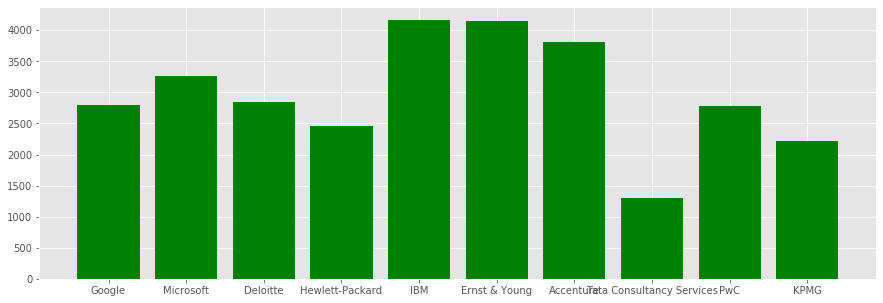

In [181]:
plt.figure(figsize=(15,5))
plt.bar(df_comp['Company'], df_comp['Frequency'], color='green')

## Collect Features based off the profiles

In [47]:
data_dict = {}

for idx in range(len(profiles)):
    
    if 'summary' in profiles[idx] and len([exp['org'] for exp in profiles[idx]['experience'] if 'org' in exp] if 'experience' in profiles[idx] else []) > 1: 
        data_dict[idx] = [profiles[idx]['_id'],
                              profiles[idx]['locality'] if 'locality' in profiles[idx] else [],
                              profiles[idx]['industry'] if 'industry' in profiles[idx] else [],
                              [exp['start'] for exp in profiles[idx]['experience'] if 'start' in exp][0] if 'experience' in profiles[idx] else [],
                              [exp['title'] for exp in profiles[idx]['experience'] if 'title' in exp][0] if 'experience' in profiles[idx] else [],
                              [exp['org'] for exp in profiles[idx]['experience'] if 'org' in exp][0] if 'experience' in profiles[idx] else [],
                             profiles[idx]['summary']]

In [233]:
len(data_dict)

12069

In [48]:
len(data_dict)

4001

In [49]:
profiles[0]['experience'][0]

{'org': 'Deloitte',
 'title': 'Manager - Financial Advisory - Advanced Analytics',
 'end': 'Present',
 'start': 'January 2012',
 'desc': 'Advanced analytics in the public and private sectors'}

### Creating the dataframe

In [242]:
df_linkedIn = pd.DataFrame.from_dict(data_dict, orient='index', columns=['Idx', 'Locality', 'Industry', 'Start', 'Title', 'Company', 'Post'])

In [245]:
df_linkedIn['Company'].value_counts()

IBM                          1804
Accenture                    1794
Microsoft                    1512
Ernst & Young                1387
Hewlett-Packard              1162
Google                       1152
Deloitte                     1012
PwC                           862
KPMG                          740
Tata Consultancy Services     644
Name: Company, dtype: int64

In [254]:
[df_linkedIn['Company'].unique()]

[array(['Google', 'Microsoft', 'Deloitte', 'Hewlett-Packard', 'IBM',
        'Ernst & Young', 'Accenture', 'Tata Consultancy Services', 'KPMG',
        'PwC'], dtype=object)]

In [255]:
[i for i in df_linkedIn['Company'].value_counts()]

[1804, 1794, 1512, 1387, 1162, 1152, 1012, 862, 740, 644]

<BarContainer object of 10 artists>

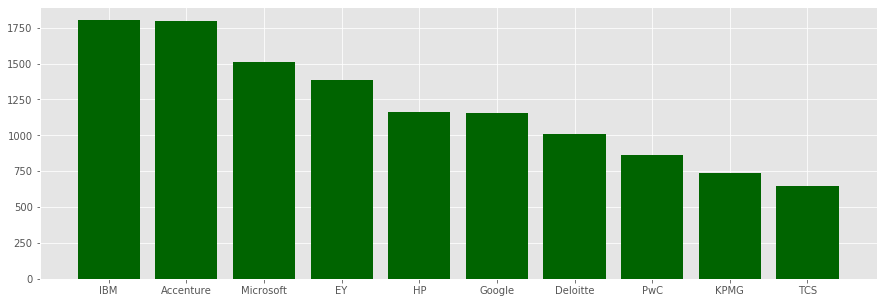

In [258]:
plt.figure(figsize=(15,5))
plt.bar(['IBM', 'Accenture', 'Microsoft', 'EY', 'HP', 'Google', 'Deloitte', 'PwC', 'KPMG', 'TCS'], [i for i in df_linkedIn['Company'].value_counts()], color='darkgreen')

In [259]:
df_linkedIn.head()

,Idx,Locality,Industry,Start,Title,Company,Post
0,in-101943,"Amsterdam Area, Netherlands",Computersoftware,February 2011,Head Enterprise Search EMEA,Google,Currently run Google's Enterprise Search Divis...
1,in-1brianhansen,"Redmond, Washington",Information Technology and Services,July 2012,"Senior Director, Venture Integration - Operations",Microsoft,"In the area of Mergers & Acquisition, we lead ..."
2,in-1bryanrichardson,"Toronto, Canada Area",Management Consulting,January 2012,Manager - Financial Advisory - Advanced Analytics,Deloitte,I help clients with risk management and fact b...
3,in-1rickharris,"Toronto, Canada Area",Computer Software,August 2012,Technical Project Manager,Hewlett-Packard,Rick Harris is an experienced Technical Consul...
9,in-5imonfletcher,"Cleveland, United Kingdom",Outsourcing/Offshoring,September 2006,Head of Outsource Operations,IBM,A motivated and committed inspirational Senior...


In [266]:
df_linkedIn['Locality'].value_counts()[:20]

San Francisco Bay Area         564
London, United Kingdom         460
Greater Seattle Area           393
Greater New York City Area     376
Bengaluru Area, India          352
Ireland                        255
Mumbai Area, India             212
Sydney Area, Australia         204
New Delhi Area, India          179
Argentina                      177
São Paulo Area, Brazil         167
Toronto, Canada Area           166
Melbourne Area, Australia      156
Singapore                      153
Hyderabad Area, India          153
China                          152
Greater Chicago Area           141
Washington D.C. Metro Area     131
United Kingdom                 128
Bengaluru, Karnataka, India    119
Name: Locality, dtype: int64

In [278]:
df_linkedIn['Industry'].apply(lambda x:re.findall(r'[a-z]+', str(x)))[:3]

0                        [omputersoftware]
1    [nformation, echnology, and, ervices]
2                   [anagement, onsulting]
Name: Industry, dtype: object

In [280]:
#df_linkedIn.to_csv('linkedIn_data.csv')

In [284]:
# get word count
df_linkedIn['wc'] = df_linkedIn['Post'].apply(lambda x:len(x.split()))

Text(0.5, 1.0, 'Word Count Distribution in Summary')

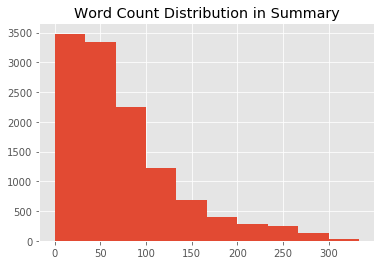

In [297]:
plt.hist(df_linkedIn['wc'])
plt.title('Word Count Distribution in Summary')

In [288]:
df_linkedIn['wc'].describe()

count    12069.000000
mean        74.119563
std         61.367527
min          0.000000
25%         29.000000
50%         58.000000
75%         99.000000
max        333.000000
Name: wc, dtype: float64

In [296]:
df_linkedIn['Post'][9]

'A motivated and committed inspirational Senior Leader in the contact centre industry, with 17 years experience, both in business process outsourcing and a client environment. Results focused with achievements in all aspects of call centre performance and people management, resulting in the best customer experience in the most productive business environment.For the past five years held senior management responsibility for a delivery team of over 1,000 specialists across 4 delivery centres in the UK and India. A proven track record in delivering improvements in productivity, customer satisfaction and profitability.Currently looking for new opportunities in the outsourcing or customer operations sectors.'

In [298]:
len(df_linkedIn)

12069

## Doing this for the Big4 comparison

In [50]:
df_big4 = pd.DataFrame.from_dict(data_dict, orient='index', columns=['Idx', 'Locality', 'Industry', 'Start', 'Title', 'Company', 'Post'])

In [78]:
df_big4.head()

,Idx,Locality,Industry,Start,Title,Company,Post
0,in-1bryanrichardson,"Toronto, Canada Area",Management Consulting,January 2012,Manager - Financial Advisory - Advanced Analytics,Deloitte,I help clients with risk management and fact b...
2,in-781985,Greater Philadelphia Area,Accounting,May 2012,"Senior, Transaction Advisory Services",Ernst & Young,Experience and Skills• Planning and executing ...
5,in-aandrewliu,"Shanghai City, China",Accounting,October 2010,Actuarial Senior,Ernst & Young,FSA 2010
6,in-aaronssmith,"Ottawa, Canada Area",Management Consulting,2012,Manager Advisory Performance Improvement,Ernst & Young,\tProven senior management‐level leadership s...
7,in-aashishkasad,"Mumbai Area, India",Accounting,April 2012,Partner,Ernst & Young,"Advisor on international tax, transfer pricing..."


In [67]:
data_dict = {}

for idx in range(len(short_tenure_profiles)):
    
    if 'summary' in short_tenure_profiles[idx] and len([exp['org'] for exp in short_tenure_profiles[idx]['experience'] if 'org' in exp] if 'experience' in short_tenure_profiles[idx] else []) > 1: 
        data_dict[idx] = [short_tenure_profiles[idx]['_id'],
                              short_tenure_profiles[idx]['locality'] if 'locality' in short_tenure_profiles[idx] else [],
                              short_tenure_profiles[idx]['industry'] if 'industry' in short_tenure_profiles[idx] else [],
                              [exp['start'] for exp in short_tenure_profiles[idx]['experience'] if 'start' in exp][0] if 'experience' in short_tenure_profiles[idx] else [],
                              [exp['title'] for exp in short_tenure_profiles[idx]['experience'] if 'title' in exp][0] if 'experience' in short_tenure_profiles[idx] else [],
                              [exp['org'] for exp in short_tenure_profiles[idx]['experience'] if 'org' in exp][0] if 'experience' in short_tenure_profiles[idx] else [],
                          [exp['org'] for exp in short_tenure_profiles[idx]['experience'] if 'org' in exp][1] if 'experience' in short_tenure_profiles[idx] else [],
                             short_tenure_profiles[idx]['summary']]

In [62]:
[exp['org'] for exp in short_tenure_profiles[3]['experience']]

['Deloitte Strategy Consulting',
 'KPMG',
 'University of Chicago Graduate School of Business',
 'Accenture',
 'Banco Popular',
 'BANCO POPULAR ESPAÑOL',
 'Renta 4']

In [68]:
df_short = pd.DataFrame.from_dict(data_dict, orient='index', columns=['Idx', 'Locality', 'Industry', 'Start', 'Title', 'Company', 'Prev Company',  'Post'])

In [70]:
len(df_short) 

1771

In [71]:
len(df_big4)

4001

In [76]:
df_big4.to_csv('big4_linkedin.csv', index=False)

In [77]:
df_short.to_csv('short_linkedin.csv', index=False)